## Maestría Ciencias de la Computación
### Curso: Visión Artificial
#### Integrantes:
* Abel Edmundo Borit Guitton
* Luis Alberto Borit Guitton
* Betzy Jacqueline Yarin Ramıirez

## **Tarea 1: Editor de Brillo y Contraste en Cuda C++**

* Funcionalidad del proyecto
1. Subir la Imagen en el proyecto (Google Colab)
2. Para cambiar la ruta de la imagen recién cargada ir a la línea 63
3. Modificar el brillo y contraste en las líneas 77 y 78
4. Para guardar la imagen modificada ir a las líneas (101 a 104) y descomentar según corresponda
* Importante!  **Se ha realizado este proyecto con cuda C++ (Para modificar el brillo y contraste, generar histogramas).**

 *Solo para visualizar los histogramas se está usando Python*

In [1]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -q
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -O stb_image_write.h -q

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpmmonw_ta".


In [61]:
%%cuda
#include <iostream>
#include <fstream> // Para trabajar con archivos de texto
#include <vector>  // Para almacenar los histogramas
#include <algorithm> // Para calcular el máximo del histograma
#include <cmath>  // Para redondear números
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "/content/stb_image.h"
#include "/content/stb_image_write.h"

// Función kernel para ajustar el brillo y el contraste
__global__ void adjustBrightnessContrast(unsigned char *image, int width, int height, int channels, float brightness, float contrast) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        for (int c = 0; c < channels; ++c) {
            int index = (y * width + x) * channels + c;

            float pixelValue = image[index];

            // Ajustar el brillo y el contraste
            pixelValue = pixelValue * contrast + brightness;

            // Asegurarse de que el valor del píxel esté en el rango [0, 255]
            pixelValue = fmaxf(0.0f, fminf(255.0f, pixelValue));

            image[index] = (unsigned char)pixelValue;
        }
    }
}

// Función para generar el histograma de una imagen
void generateHistogram(unsigned char *image, int width, int height, int channels, std::vector<int>& histogram) {
    histogram.assign(256, 0); // Inicializar el histograma con 256 bins (0-255)

    for (int y = 0; y < height; ++y) {
        for (int x = 0; x < width; ++x) {
            for (int c = 0; c < channels; ++c) {
                int index = (y * width + x) * channels + c;
                ++histogram[image[index]]; // Incrementar el conteo del bin correspondiente al valor del píxel
            }
        }
    }
}

// Función para guardar un histograma en un archivo de texto
void saveHistogram(const std::vector<int>& histogram, const std::string& filename) {
    std::ofstream file(filename);
    if (file.is_open()) {
        for (int i = 0; i < histogram.size(); ++i) {
            file << i << ": " << histogram[i] << std::endl;
        }
        file.close();
    } else {
        std::cerr << "Error al abrir el archivo " << filename << " para guardar el histograma." << std::endl;
    }
}

int main() {
    // Cargar la imagen desde un archivo usando la función stbi_load
    const char* filename = "/content/dog.jpg";
    int width, height, channels;
    unsigned char *img = stbi_load(filename, &width, &height, &channels, 0);
    if (!img) {
        std::cerr << "Error al cargar la imagen" << std::endl;
        return 1;
    }

    // Generar y guardar el histograma de la imagen original
    std::vector<int> originalHistogram;
    generateHistogram(img, width, height, channels, originalHistogram);
    saveHistogram(originalHistogram, "/content/img_original_histogram.txt");

    // Definir los parámetros de ajuste del brillo y el contraste
    float brightness = 0.0f;
    float contrast = 0.15f;

    // Definir el tamaño de la imagen
    size_t image_size = width * height * channels;
    printf("\nwidth = %d | height = %d\n", width, height);
    // Reservar memoria en la GPU
    unsigned char *d_img;
    cudaMalloc((void **)&d_img, image_size);

    // Copiar la imagen desde la memoria de la CPU a la memoria de la GPU
    cudaMemcpy(d_img, img, image_size, cudaMemcpyHostToDevice);

    // Definir el tamaño de bloque y el tamaño de la cuadrícula
    dim3 blockSize(32, 32);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);

    // Lanzar el kernel para ajustar el brillo y el contraste
    adjustBrightnessContrast<<<gridSize, blockSize>>>(d_img, width, height, channels, brightness, contrast);

    // Copiar la imagen ajustada desde la memoria de la GPU a la memoria de la CPU
    cudaMemcpy(img, d_img, image_size, cudaMemcpyDeviceToHost);

    // Guardar la imagen ajustada usando stbi_write
    // stbi_write_jpg("/content/brightest_image.jpg", width, height, channels, img, 100); //Test brightness = 120.0f contrast = 1.0f;
    // stbi_write_jpg("/content/dimmest_image.jpg", width, height, channels, img, 100); //Test brightness = -120.0f contrast = 1.0f;
    // stbi_write_jpg("/content/high_contrast_image.jpg", width, height, channels, img, 100); //Test brightness = 0.0f contrast = 25.0f;
    stbi_write_jpg("low_contrast_image.jpg", width, height, channels, img, 100); //Test brightness = 0.0f contrast = 0.25f;

    // Generar y guardar el histograma de la imagen transformada
    std::vector<int> transformedHistogram;
    generateHistogram(img, width, height, channels, transformedHistogram);
    saveHistogram(transformedHistogram, "/content/img_transformed_histogram.txt");

    printf("Se han generado los histogramas y la imagen modificada\n");

    // Liberar memoria en la GPU
    cudaFree(d_img);

    // Liberar la memoria de la imagen cargada
    stbi_image_free(img);

    return 0;
}



width = 1300 | height = 867
Se han generado los histogramas y la imagen modificada



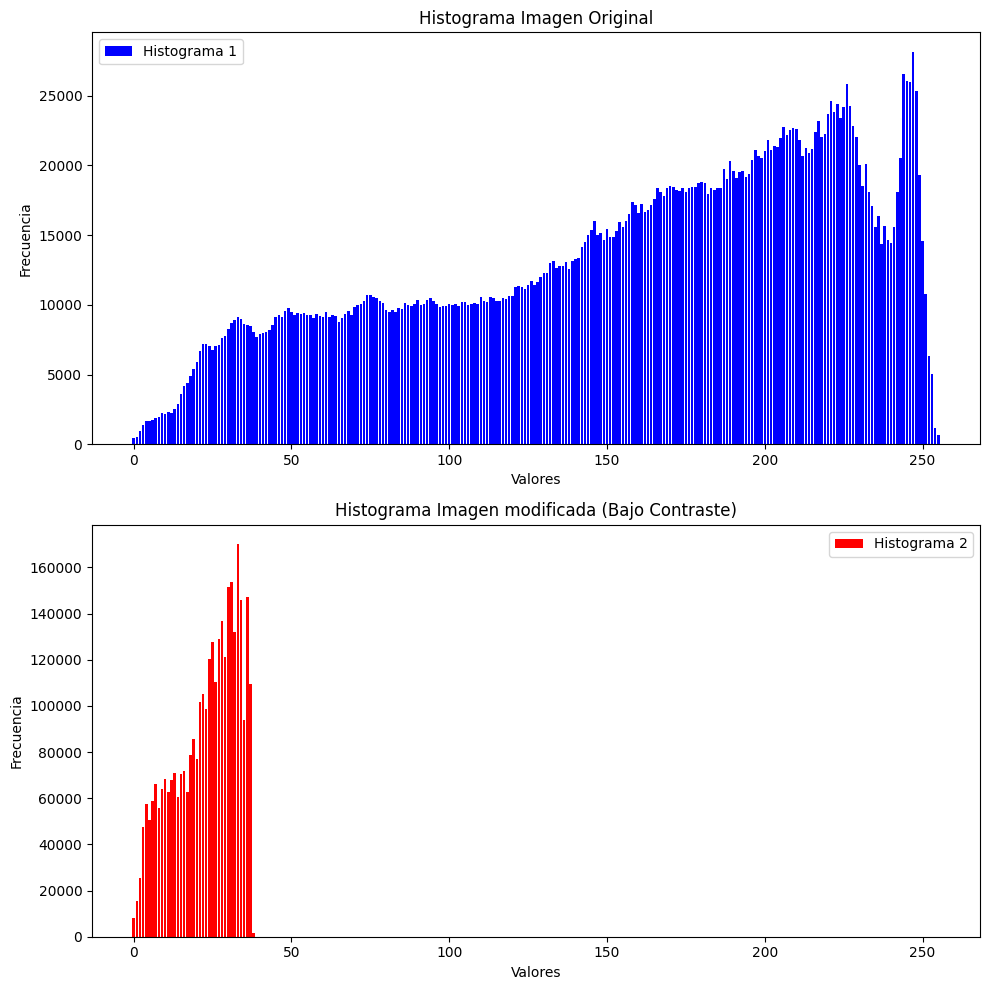

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Define la ruta a los archivos de histogramas en Google Colab
file_path_hist1 = '/content/img_original_histogram.txt'
file_path_hist2 = '/content/img_transformed_histogram.txt'

# Lee los datos de los archivos de histograma
def read_histogram(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [list(map(int, line.strip().split(':'))) for line in lines]
        data = np.array(data)
        return data[:, 0], data[:, 1]

x1, y1 = read_histogram(file_path_hist1)
x2, y2 = read_histogram(file_path_hist2)

# Crea la figura y los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Grafica el primer histograma en el primer subplot
ax1.bar(x1, y1, label='Histograma 1', color='blue')
ax1.set_xlabel('Valores')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Histograma Imagen Original')
ax1.legend()

# Grafica el segundo histograma en el segundo subplot
ax2.bar(x2, y2, label='Histograma 2', color='red')
ax2.set_xlabel('Valores')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Histograma Imagen modificada (Bajo Contraste)')
ax2.legend()

# Muestra la gráfica
plt.tight_layout()
plt.show()
